In [1]:
# Load libraries
print("Loading libraries")
library(dplyr, warn.conflicts=F)
library(tidyr, warn.conflicts=F)
library(mgcv, warn.conflicts=F)
library(ggplot2, warn.conflicts=F)
library(reshape2, warn.conflicts=F)


[1] "Loading libraries"


Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.8-7. For overview type 'help("mgcv-package")'.
Warning message:
: package ‘ggplot2’ was built under R version 3.2.4

In [2]:
print("Reading in the data")
dh.data = tbl_df(read.csv('../data/dh-PNC.csv', header=T))

[1] "Reading in the data"


Warning message:
In doTryCatch(return(expr), name, parentenv, handler): unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 6): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: /Library/Frameworks/R.framework/Resources/modules//R_X11.so
  Reason: image not foundWarning message:
In svg(tf, width, height, pointsize, FALSE, family, bg, antialias): unable to load shared object '/Library/Frameworks/R.framework/Resources/library/grDevices/libs//cairo.so':
  dlopen(/Library/Frameworks/R.framework/Resources/library/grDevices/libs//cairo.so, 6): Library not loaded: /opt/X11/lib/libXrender.1.dylib
  Referenced from: /Library/Frameworks/R.framework/Resources/library/grDevices/libs//cairo.so
  Reason: image not foundWarning message:
In svg(tf, width, height, pointsize, FALSE, family, bg, antialias): failed to load cairo DLLWarning message:
In file(con, "rb"): cannot open f

ERROR: Error in file(con, "rb"): cannot open the connection


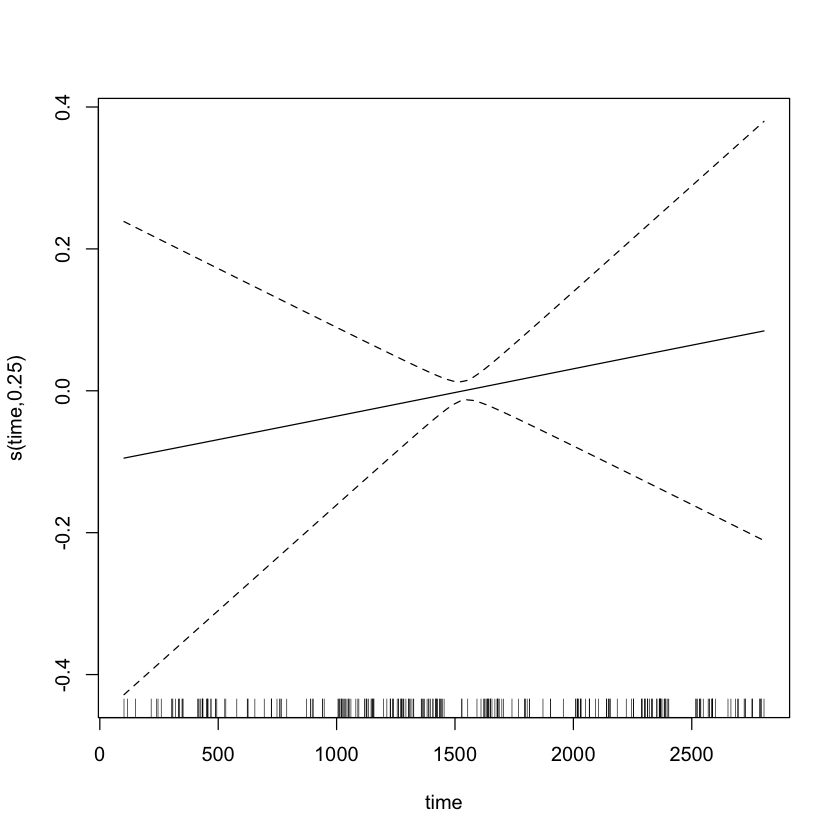

ERROR: Error in file(con, "rb"): cannot open the connection


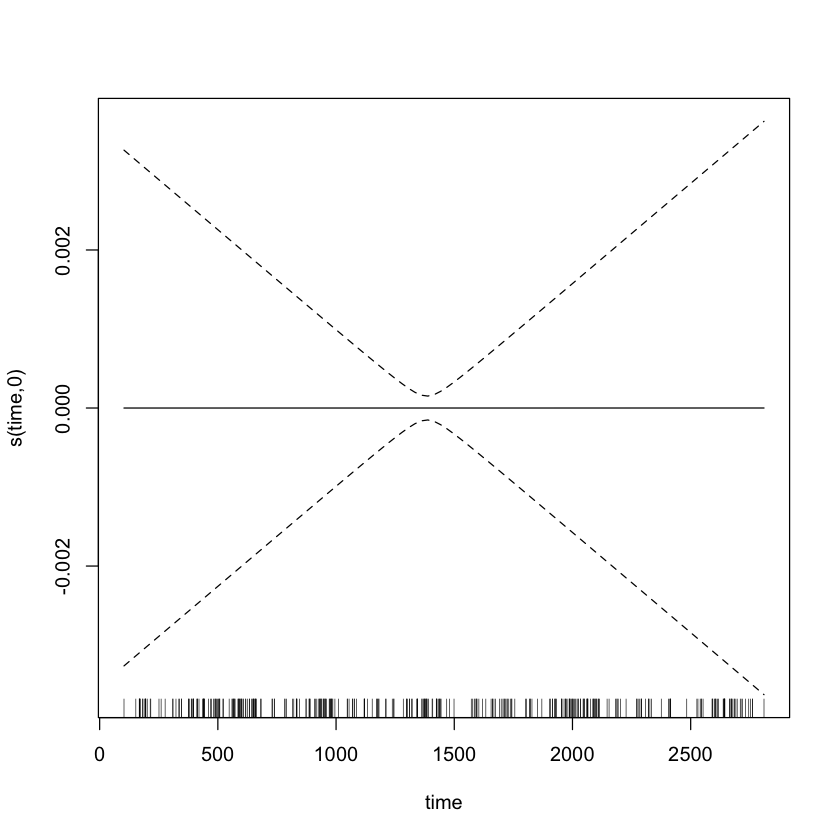

In [3]:
models = list() # Fitted models
results = data.frame() # Features of models
values = data.frame() # Predicted contribution of smooth term

for (s in unique(dh.data$speaker)) {
  this.data = dh.data %>% filter(speaker == s)
  mod0 = gam(obs ~ prev*log.lag, family="binomial", data = this.data)
  mod = gam(obs ~ s(time, bs='ts') + prev*log.lag, family="binomial", data = this.data) #, select=T)
  # Interpretation of coefficients
  # prev1:  when you say 'that' you're more likely to say 'that again
  # log(lag): decay back towards baseline after saying 'dat'
  # prev1:log(lag): priming decay and move back to baseline
  models[[s]] = list(mod0, mod)
  # (1) Smooth function of time
  logit = plot.gam(mod)[[1]]$fit
  pred = 1/(1 + exp(logit))
  pred = pred - mean(pred)
  # Add s(time) values to data frame
  values.df = data.frame(speaker=rep(s,100),x=c(1:100),pred)
  values = rbind(values.df, values)
  # (2) Priming estimate
  priming = coef(mod)["prev"]
  # (3) delta AIC
  delta.AIC = mod0$aic - mod$aic
  # (4) Estimated degrees of freedom from s(time)
  edf = summary(mod)$edf
  # Add to results data frame
  results.df = data.frame(speaker=s, priming=priming,
                          priming.p=1/(1+exp(priming)),
                          delta.AIC=delta.AIC,
                          smooth.improve=(delta.AIC > 2), #as.numeric(delta.AIC > 2),
                          edf=edf,
                          n=nrow(this.data))
  results = rbind(results.df, results)
}

In [4]:
results = tbl_df(results)


ERROR: Error in file(con, "rb"): cannot open the connection


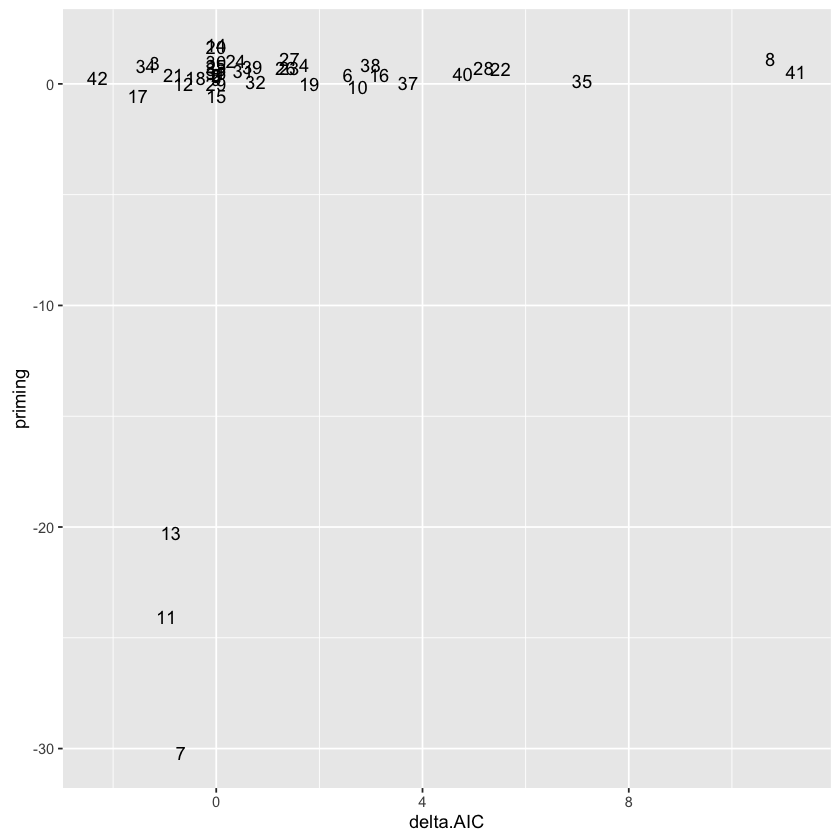

ERROR: Error in file(con, "rb"): cannot open the connection


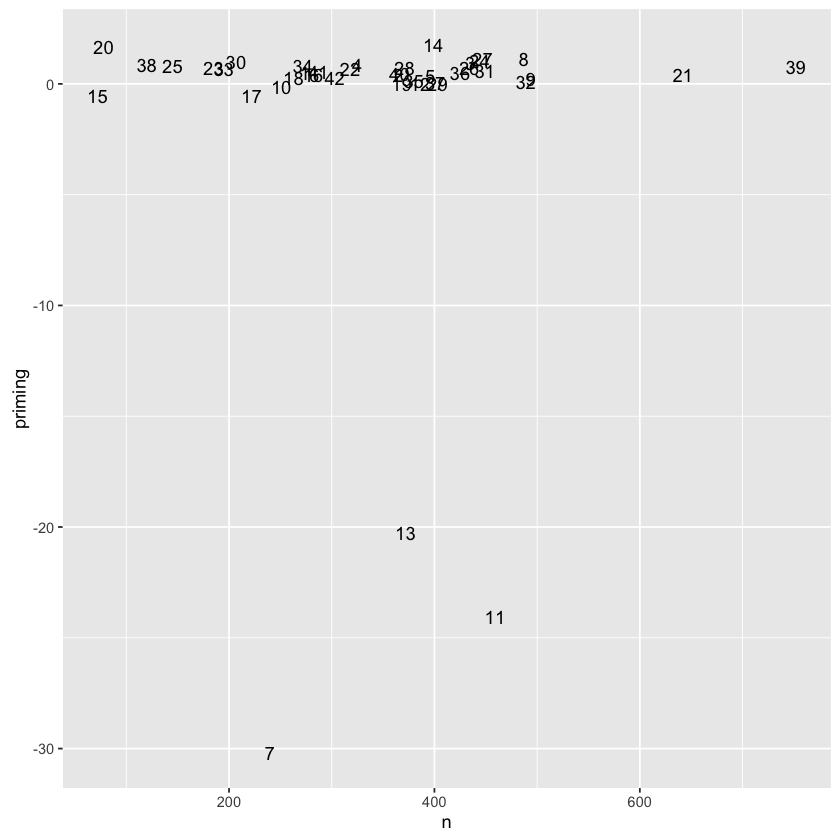

In [5]:
# We can see that
ggplot(results, aes(x=delta.AIC, y=priming, label=speaker)) +
  geom_text()
ggplot(results, aes(x=n, y=priming, label=speaker)) +
  geom_text()


In [6]:
# Filter speakers
results = results %>% filter(! speaker %in% c(7,11,13))
values = tbl_df(values) %>% filter(! speaker %in% c(7,11,13))




	Pearson's product-moment correlation

data:  results$delta.AIC and results$n
t = 0.2848, df = 37, p-value = 0.7774
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2727734  0.3570176
sample estimates:
       cor 
0.04676879 


ERROR: Error in file(con, "rb"): cannot open the connection


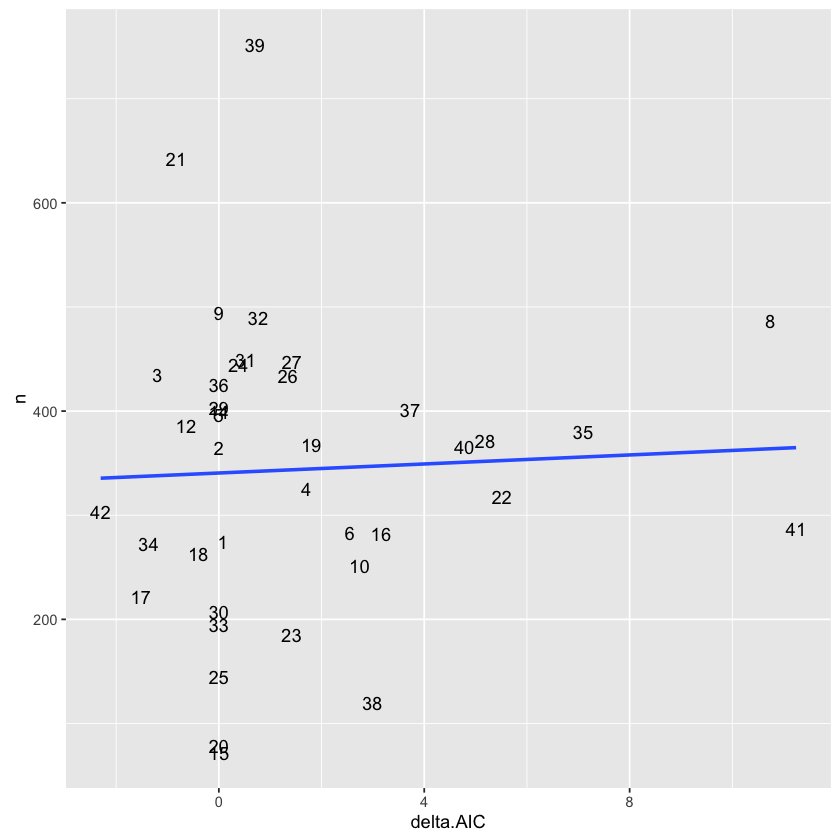


	Pearson's product-moment correlation

data:  results$delta.AIC and results$priming
t = 0.53529, df = 37, p-value = 0.5957
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2343357  0.3923285
sample estimates:
       cor 
0.08766286 



	Pearson's product-moment correlation

data:  results$priming and results$n
t = 0.18294, df = 37, p-value = 0.8558
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2881892  0.3423313
sample estimates:
       cor 
0.03006124 



	Pearson's product-moment correlation

data:  results$edf and results$delta.AIC
t = 4.1132, df = 37, p-value = 0.0002087
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2971635 0.7441550
sample estimates:
      cor 
0.5601599 


ERROR: Error in file(con, "rb"): cannot open the connection


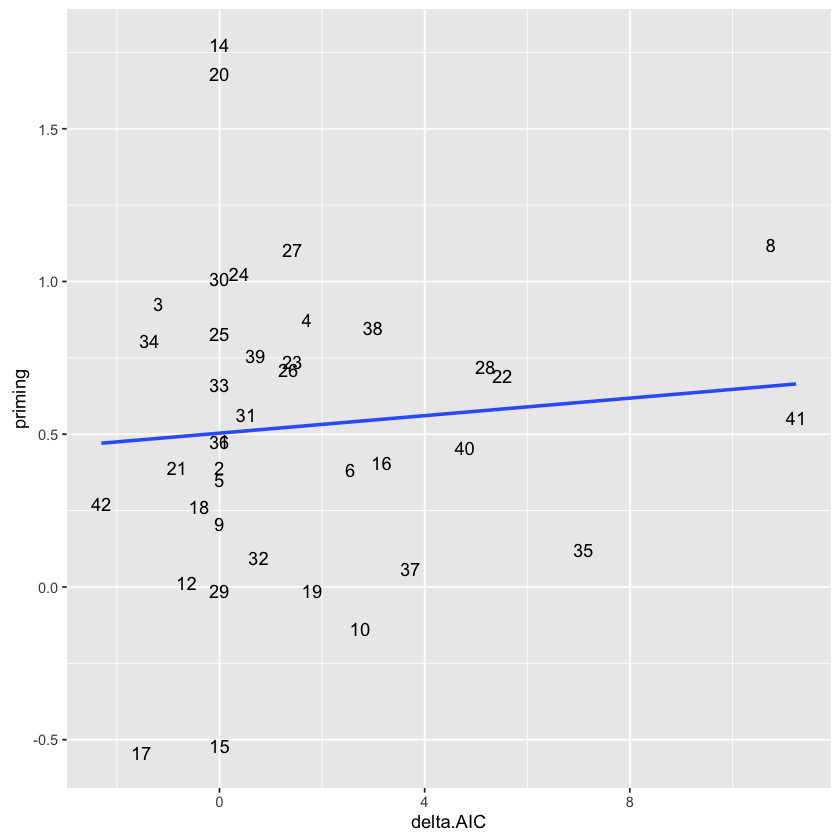

In [7]:
# Can we only detect model improvement for speakers with lots of data?
ggplot(results, aes(x=delta.AIC, y=n, label=speaker)) +
  geom_text() + geom_smooth(method='lm', se=F)
cor.test(results$delta.AIC, results$n)
  # Seeing an improvement in the model fit is not linearly correlated
  # with the number of data points for the speaker

# Does detecting model improvement change results for priming?
ggplot(results, aes(x=delta.AIC, y=priming, label=speaker)) +
  geom_text() + geom_smooth(method='lm', se=F)
cor.test(results$delta.AIC, results$priming)
  # Seeing an improvement in the model is not linearly correlated
  # with the size of the priming coefficient

# Is our estimate of priming affected by the amount of data?
ggplot(results, aes(x=priming, y=n, label=speaker)) +
  geom_text() + geom_smooth(method='lm', se=F)
cor.test(results$priming, results$n)
  # The priming coefficient estimates are not linearly correlated
  # with the number of data points for the speaker

# Do model improvements correspond to higher estimated degrees of freedom?
ggplot(results, aes(x=edf, y=delta.AIC, label=speaker)) +
  geom_text() + geom_smooth(method='lm', se=F) + geom_hline(yintercept=2)
cor.test(results$edf, results$delta.AIC)
  # The estimated degrees of freedom are linearly correlated with the
  # improvement in the full model



	Shapiro-Wilk normality test

data:  unique(results$priming)
W = 0.97633, p-value = 0.5719


ERROR: Error in file(con, "rb"): cannot open the connection


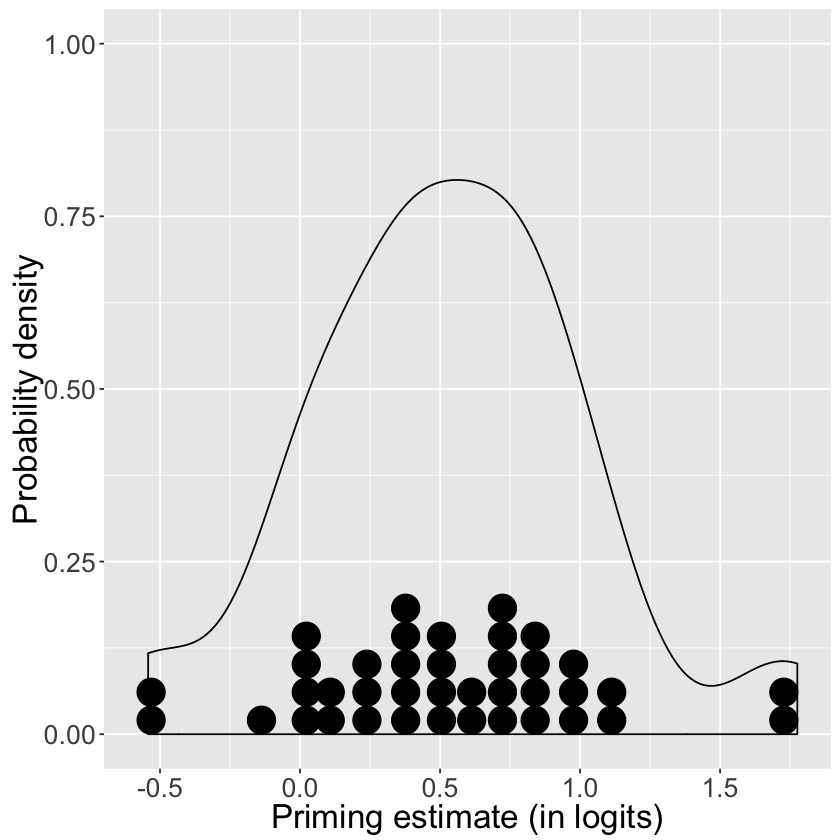

In [8]:
# 
ggplot(results, aes(x=priming)) + geom_density() +
  geom_dotplot(binwidth=.1) +
  ylab("Probability density") +
  xlab("Priming estimate (in logits)") + theme(text = element_text(size=20))
# ggsave()
# These logit priming estimates are normally distributed
shapiro.test(unique(results$priming))


In [9]:

# Join the 
mod.smooths = tbl_df(full_join(values, results, by="speaker"))

ERROR: Error in file(con, "rb"): cannot open the connection


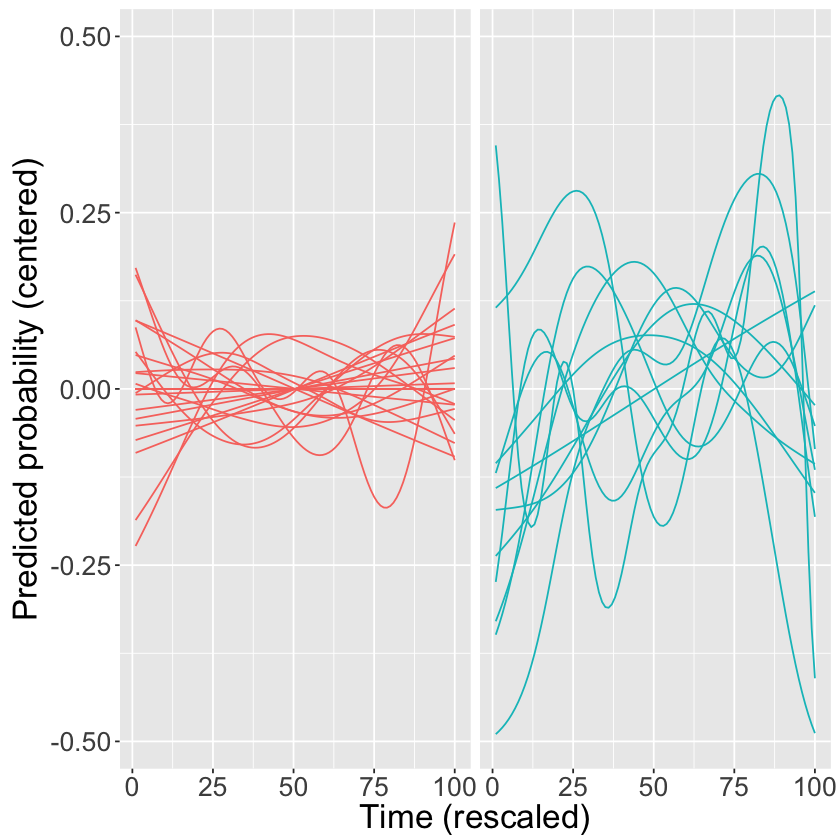

ERROR: Error in file(con, "rb"): cannot open the connection


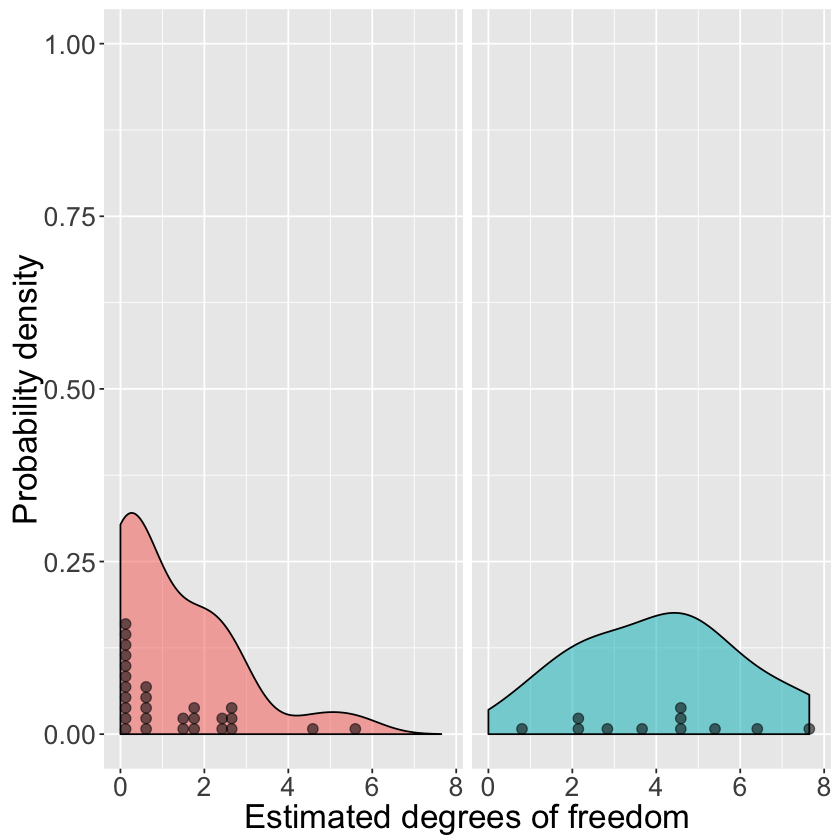

In [10]:
range = max(abs(mod.smooths$pred))
ggplot(mod.smooths, aes(x=x, y=pred, group=speaker, color=smooth.improve)) +
  geom_line() +  # aes(alpha=(1 - edf/max(edf))*.8 + edf/max(edf))
  facet_wrap(~ smooth.improve) +
  xlab("Time (rescaled)") +
  ylab("Predicted probability (centered)") +
  ylim(-range,range) +
  theme(legend.position="none", text = element_text(size=20), strip.text = element_blank()) #  # Remove TRUE and FALSE labels
#ggsave(file='dynamic-style-LV.pdf')

ggplot(results, aes(x=edf)) +
  geom_density(aes(fill=smooth.improve, alpha=.5)) +
  geom_dotplot(aes(alpha=.5), binwidth=.25) + facet_wrap(~ smooth.improve) +
 xlab("Estimated degrees of freedom") + ylab("Probability density") +
 theme(legend.position="none", text = element_text(size=20), strip.text = element_blank())  # Remove TRUE and FALSE labels
#ggsave(file='edf-dynamic.pdf')


In [ ]:
s